# Execution Tutorial 2: Expected Values and Parameterized Quantum Programs

This tutorial covers the basics of measuring Pauli strings and executing a parameterized quantum program using Classiq via Python SDK. Alternatively, you can use the [Classiq Platform](https://platform.classiq.io) to execute quantum algorithms.

A parameterized quantum program is a quantum circuit with adjustable parameters, such as angles in rotation gates, that can be tuned to alter the circuit's behavior. Think of it like tuning a camera with adjustable settings: the camera (the circuit) stays the same, but adjusting the settings (parameters) changes the captured images (outputs). In quantum computing, tuning these parameters helps identify the configuration that yields the most useful results. These programs are particularly useful in quantum machine learning and optimization, where the goal is to find the best parameter set.

First, we create a parameterized quantum program using two qubits. The program applies an X gate, a parameterized RY rotation, and a CNOT gate. The rotation angle is controlled by a variable called `angle`.

In [17]:
from classiq import *


@qfunc
def main(x: Output[QBit], y: Output[QBit], angle: CReal) -> None:
    allocate(x)
    allocate(y)
    X(x)
    RY(angle, x)
    CX(x, y)


qprog = synthesize(main)

The first thing we can do is to sample the outputs of the quantum program for a given parameter. For example, $\pi / 2$.

We can now execute the quantum program and obtain a sample of output states using `ExecutionSession`. To do this, we define the parameter values using a dictionary.

In [18]:
import numpy as np

# Set angle parameter to pi/2 for sampling
parameter = {"angle": np.pi / 2}

After generating the `ExecutionSession`, it is possible to show the counts for this particular parameter value:

In [19]:
with ExecutionSession(qprog) as es:
    first_sample = es.sample(parameter)

print("Counts for angle = pi/2", first_sample.counts)

Counts for angle = pi/2 {'00': 1007, '11': 1041}


Running your circuit with different parameter values helps explore how the output changes, revealing trends or minima in a cost function. This is especially useful in quantum optimization. As an example, we’ll evaluate the circuit over 50 values of `angle` from $0$ to $\pi$.

In [20]:
# Create a list of 50 angle values from 0 to 2π
angles_list = np.linspace(0, 2 * np.pi, 50)
parameters_list = [{"angle": angles} for angles in angles_list]

# Execute batch sampling over all angles
with ExecutionSession(qprog) as es:
    second_sample = es.batch_sample(parameters_list)

The result of `batch_sample` is a list of results, one for each angle value.

In [21]:
type(second_sample)

list

Therefore, we can analyze the data from each parameter on `angles_list`. For example, an interesting way of analyzing this data is to plot the number of counts of the states $|00\rangle$ and $|11\rangle$ as functions of `angle`:

In [22]:
# extract counts of |11> and |00> for each result

pops_00 = [pops.counts.get("00", 0) for pops in second_sample]
pops_11 = [pops.counts.get("11", 0) for pops in second_sample]

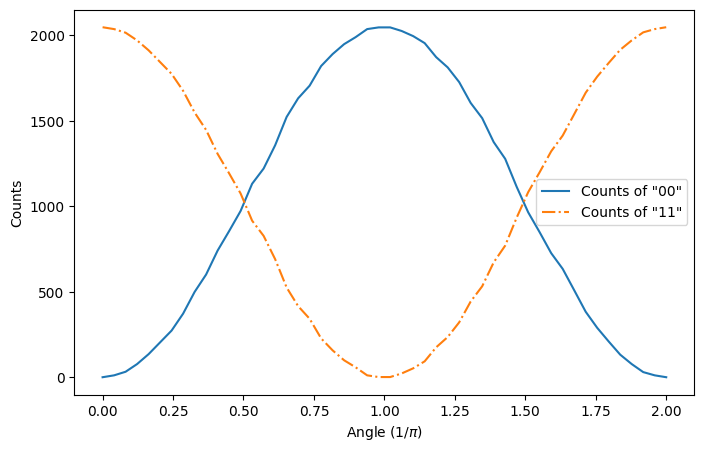

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(angles_list / np.pi, pops_00, label='Counts of "00"')
plt.plot(angles_list / np.pi, pops_11, label='Counts of "11"', linestyle="-.")

plt.xlabel(r"$\mathrm{Angle} \; (1/\pi)$")
plt.ylabel("Counts")
plt.legend()
plt.show()

## Measuring Pauli Strings

Measuring observables from a quantum program turns out to be necessary when you want to obtain information that can't be accessed only from the populations of states. For this end, you can measure Pauli Strings using Classiq. As an example, if we want to measure how close the output of our system is to the Bell state: 

\begin{equation*}
|\Phi^- \rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right),
\end{equation*}

it is possible measure the expected value of its projection:

\begin{equation*}
P(\Phi^-) = |\Phi^- \rangle \langle \Phi^- | = \frac{1}{2} \left( |00\rangle + |11\rangle \right) \left( \langle00| + \langle 11| \right) = \frac{1}{2} \left ( |00\rangle \langle 00| + |00\rangle \langle 11 | + |11 \rangle \langle 00 | + |11\rangle \langle |11\right).
\end{equation*}

The projector operator, by its turn, can be represented as a Pauli string:

\begin{equation*}
P(\Phi^-) = \frac{1}{4} \left( II + XX - YY + ZZ \right)
\end{equation*}

Therefore, if we want to measure the projector expected value for some output of the quantum circuit, say angle $= \pi/5$, it is possible using `estimate` and `ExecutionSession`. For this, first we need to define the Pauli Strings to be measured:

In [24]:
projector_operator = [
    PauliTerm(pauli=[Pauli.I, Pauli.I], coefficient=0.25),
    PauliTerm(pauli=[Pauli.X, Pauli.X], coefficient=0.25),
    PauliTerm(pauli=[Pauli.Y, Pauli.Y], coefficient=-0.25),
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=0.25),
]

Now, using `ExecutionSession`, evaluate the expected value of the output:

In [25]:
parameter = {"angle": np.pi / 5}

with ExecutionSession(qprog) as es:
    first_estimate = es.estimate(projector_operator, parameter)

print("Expected value for angle = pi/5: ", first_estimate.value)

Expected value for angle = pi/5:  (0.22802734375+0j)


The same can be done in batches, for example, if we want to plot a graph of fidelity between the output of the quantum program and the $|\Phi^-\rangle$ state:

In [26]:
with ExecutionSession(qprog) as es:
    second_estimate = es.batch_estimate(projector_operator, parameters_list)

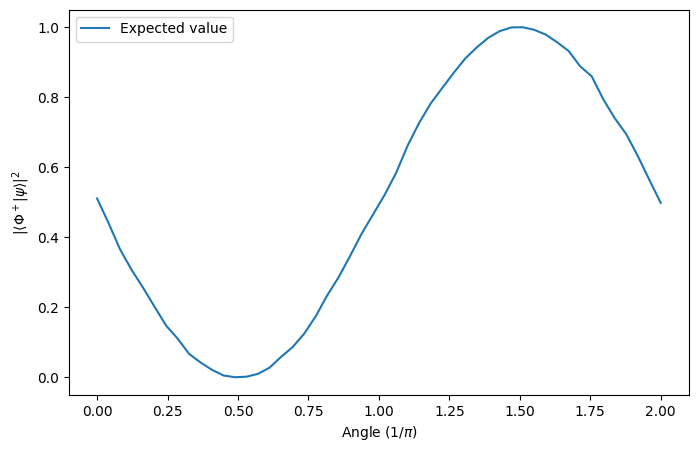

In [27]:
values = [measurement.value.real for measurement in second_estimate]
plt.figure(figsize=(8, 5))
plt.plot(angles_list / np.pi, values, label="Expected value")

plt.xlabel(r"$\mathrm{Angle} \; (1/\pi)$")
plt.ylabel(r"$|\langle \Phi^+ | \psi \rangle |^2$")
plt.legend()
plt.show()

## Application: Variational Quantum Circuit to Prepare a Bell State

In this additional session, we create a simple parameterized quantum algorithm that prepares the Bell State $|\Phi^- \rangle = |00\rangle - |11 \rangle$. For this, an ansatz with two parameters is constructed:

In [28]:
@qfunc
def main(
    x: Output[QBit], y: Output[QBit], angles: CArray[CReal, 2]
):  # Note that now angles are declared as a CArray[CReal, 2], where 2 represents its length
    allocate(x)
    allocate(y)
    RX(angles[0], x)
    RY(angles[1], x)
    CX(x, y)


qprog = synthesize(main)

Now, we define the projector of the Bell State, which is the operator we will be measuring:

In [29]:
projector_operator_new = [
    PauliTerm(pauli=[Pauli.I, Pauli.I], coefficient=0.25),
    PauliTerm(pauli=[Pauli.X, Pauli.X], coefficient=-0.25),
    PauliTerm(pauli=[Pauli.Y, Pauli.Y], coefficient=0.25),
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=-0.25),
]

We can also define the function that is subject to classical optimization. Note that we want the expected value as high as possible, so we actually want to minimize $1-|\langle \Phi^- | \psi \rangle|^2 $

In [30]:
def cost_function(angles):
    # First format the inputs of angles (considered here to be numpy arrays) to a dictionary
    angles_dict = {"angles": angles.tolist()}
    # Use ExecutionSession to estimate the expected value of the projector operator
    with ExecutionSession(qprog) as es:
        expected_value = es.estimate(projector_operator_new, angles_dict)
    # Evalute the cost function
    return 1 - expected_value.value.real

The final step is to perform the optimization of the cost function defined by the quantum ansatz. In this tutorial, the `minimize` method from the scipy library will be employed.

In [31]:
from scipy.optimize import minimize

res = minimize(fun=cost_function, x0=np.random.rand(2), method="COBYLA")

In [32]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.5
       x: [ 3.142e+00  1.572e+00]
    nfev: 33
   maxcv: 0.0


These values corresponds to the quantum circuit that generates this Bell Statem using X and RY gates.

## Final Remarks


In this tutorial, we built a simple parameterized quantum circuit, explored sampling it with specific parameter values, and visualized how output probabilities vary with those parameters. At the end, a simple Variational Quantum Algorithm is presented to prepare a Bell State.

These techniques form the foundation for building and optimizing more complex quantum algorithms.